In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
 #STEP 1: Load Dataset
# =====================================================
df = pd.read_csv("/content/usd_amount_dataset.csv")
print("✅ Dataset loaded successfully!")
print(df.head())


✅ Dataset loaded successfully!
                         transaction_id account_key transaction_date  \
0  eb87234e-db1f-4019-a1b6-4d24b0e882cf     ACC3162       04-09-2025   
1  17fea564-5bef-49b3-94de-0846b4ebd8c9     ACC3350       15-08-2025   
2  3065f8dd-e2a9-4ea9-a041-6d01c2739c7f     ACC8252       30-08-2025   
3  d63757d1-ee1d-4aa6-ba8f-bbcc1e37156b     ACC6500       22-08-2025   
4  f207dcd6-f136-44ea-9d0c-a091d8494005     ACC1171       24-08-2025   

   originator_name              originator_address1 originator_address2  \
0       Lisa Velez                   1538 Lee Forge           Markmouth   
1       Robin York                1472 Clark Canyon           New Laura   
2  Cynthia Mathews                 4878 Lori Forges   Richardsonborough   
3       Lisa Adams  217 Patricia Turnpike Suite 292        Lake Micheal   
4    Cody Gonzalez    802 Melissa Orchard Suite 099          Alexisfort   

  originator_country   beneficiary_name            beneficiary_address1  \
0         

In [3]:
df['amount_usd'] = df['amount_usd'].astype(int)

In [4]:
# STEP 2: Define Reference Data
# =====================================================
exchange_rates = {
    'USD': 1.00, 'EUR': 0.91, 'GBP': 0.78,
    'INR': 83.20, 'CNY': 7.10, 'JPY': 142.50,
    'AED': 3.67, 'BRL': 5.00
}

high_risk_countries = {
    "Level_1": ["DE", "US", "FR", "GB", "CA"],  # low risk
    "Level_2": ["AE", "BR", "IN", "ZA", "MX"],  # medium
    "Level_3": ["IR", "KP", "SY", "RU", "CU"]   # high
}

suspicious_keywords = [
    "gift", "donation", "offshore", "cash", "urgent",
    "invoice 999", "crypto", "Hawala", "Shell", "bearer", "sensitive"
]


In [5]:
def apply_country_score(country):
    if country in high_risk_countries["Level_1"]:
        return 2
    elif country in high_risk_countries["Level_2"]:
        return 4
    elif country in high_risk_countries["Level_3"]:
        return 10
    else:
        return 0

df["beneficiary_country_score"] = df["beneficiary_country"].apply(apply_country_score)
df["originator_country_score"] = df["originator_country"].apply(apply_country_score)


In [6]:
df["originator_country_score"]

,originator_country_score
0,4
1,10
2,10
3,10
4,2
...,...
99995,2
99996,10
99997,10
99998,4


In [7]:
 #Rule 2: Suspicious keyword in payment_instruction
def keyword_score(text):
    text = str(text).lower()
    for kw in suspicious_keywords:
        if kw.lower() in text:
            return 3
    return 0

df["suspicious_keyword_score"] = df["payment_instruction"].apply(keyword_score)

In [8]:
# Rule 3: Amount > $1,000,000 USD
df["amount_gt_1m_score"] = np.where(df["amount_usd"] > 1_000_000, 3, 0)

In [9]:
# Step 1 — Ensure transaction_date is datetime
df['transaction_date']= pd.to_datetime(df['transaction_date'], errors='coerce')
#Step 2 — Sort by account and date
df = df.sort_values(['account_key', 'transaction_date'])

# Step 3 — Initialize structuring score column
df['structuring_score'] = 0

# Step 4 — Loop through each account and check 3-day windows
for acc, group in df.groupby('account_key'):
    group = group.sort_values('transaction_date').reset_index()

    for i in range(len(group)):
        # Define 3-day window (current date ± 1.5 days)
        start_date = group.loc[i, 'transaction_date']
        end_date = start_date + pd.Timedelta(days=3)

        # Filter transactions in 3-day range and 8k–9.9k range
        window_txns = group[
            (group['transaction_date'] >= start_date) &
            (group['transaction_date'] < end_date) &
            (group['amount_usd'] >= 800000) &
            (group['amount_usd'] <= 999999)
        ]

        # Check if sum in this 3-day window > $1M
        if window_txns['amount_usd'].sum() > 1_000_000:
            # Assign risk score 5 to those transactions
            df.loc[window_txns['index'], 'structuring_score'] = 5


In [10]:
df['structuring_score']

,structuring_score
93505,0
15247,0
94062,0
96769,0
43597,0
...,...
38147,0
41690,0
58398,0
78499,0


In [11]:
# Rule 5: Rounded amounts
def rounded_score(amount):
    if amount % 1000 == 0:
        return 2
    return 0

df["rounded_amount_score"] = df["transaction_amount"].apply(rounded_score)

In [12]:

df["rounded_amount_score"]

,rounded_amount_score
93505,0
15247,0
94062,0
96769,0
43597,2
...,...
38147,0
41690,0
58398,0
78499,0


In [14]:
df["account_txn_count"] = df.groupby("account_key")["transaction_id"].transform("count")
df["account_txn_count"]

,account_txn_count
93505,15
15247,15
94062,15
96769,15
43597,15
...,...
38147,11
41690,11
58398,11
78499,11


In [15]:
# =====================================================
# STEP 4: Additional Feature Engineering
# =====================================================

# Transaction count per account (velocity feature)
df['account_txn_count'] = df.groupby('account_key')['transaction_id'].transform('count')

# Time-based features
df['day_of_week'] = df['transaction_date'].dt.dayofweek
df['hour_of_day'] = df['transaction_date'].dt.hour
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Cross-border transaction indicator
df['is_cross_border'] = (df['originator_country'] != df['beneficiary_country']).astype(int)

# Payment type encoding
payment_type_risk = {'SWIFT': 3, 'IMPS': 2, 'NEFT': 1}
df['payment_type_risk'] = df['payment_type'].map(payment_type_risk).fillna(0)

# Aggregate rule scores
df["aggregate_score"] = (
    df["beneficiary_country_score"] +
    df["originator_country_score"] +
    df["suspicious_keyword_score"] +
    df["amount_gt_1m_score"] +
    df["structuring_score"] +
    df["rounded_amount_score"]
)

In [16]:
df

,transaction_id,account_key,transaction_date,originator_name,originator_address1,originator_address2,originator_country,beneficiary_name,beneficiary_address1,beneficiary_address2,...,amount_gt_1m_score,structuring_score,rounded_amount_score,account_txn_count,day_of_week,hour_of_day,is_weekend,is_cross_border,payment_type_risk,aggregate_score
93505,b0183ebf-50d3-4013-81a6-b9749ca5c6f8,ACC1000,2025-02-09,Ronald Clark,5233 Schmidt Via Apt. 890,Riverastad,KP,April Avila,462 Harris Well Suite 760,New Pamelabury,...,3,0,0,15,6.0,0.0,1,1,0.0,26
15247,6173f5ec-742f-4716-a0e3-24200b0ce4e1,ACC1000,2025-04-09,James Grimes,02143 Justin Forge,New Nicholasside,ZA,Nathan Patterson,374 Michael Place,Millerview,...,3,0,0,15,2.0,0.0,0,1,0.0,9
94062,90135f67-57eb-4546-a770-5d44f7267664,ACC1000,2025-04-09,Rhonda Ortiz,7929 Barnes Lodge Apt. 458,East Amberport,US,Kayla Williams,5701 Freeman Corners,New Tiffany,...,3,0,0,15,2.0,0.0,0,1,0.0,15
96769,80f9e583-cfbd-44b0-b22c-e85736948573,ACC1000,2025-07-09,Melissa Salazar,278 Cunningham Dale Apt. 022,Lewischester,BR,Amanda Henry,84106 Heather Grove,East Christopher,...,3,0,0,15,2.0,0.0,0,1,3.0,17
43597,ce7869fb-2c6e-4945-be3c-731bbca629b0,ACC1000,2025-08-09,Matthew Moran,45479 Johnson Alley Apt. 223,Natashamouth,MX,Tiffany Gonzalez,4322 Brooks Road Suite 428,Hernandezburgh,...,0,0,2,15,5.0,0.0,1,0,2.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38147,28ad0557-0051-4d01-9d74-58a6204bd1fa,ACC9999,NaT,Scott Simmons,31545 Brown Prairie Suite 189,Port Amy,DE,Keith Williams MD,41415 Joshua Meadow,Campbellhaven,...,3,0,0,11,NaN,NaN,0,1,0.0,7
41690,27a9ae15-1064-4f88-9fad-85cf6c1a89e4,ACC9999,NaT,Mr. Christopher Clark DDS,64566 Larson Pass,South Nicolefort,CA,Laura Lee,2069 Nathan Camp,Sydneyport,...,3,0,0,11,NaN,NaN,0,1,3.0,7
58398,c7f9346c-d1ad-411a-8955-cb39c0d05463,ACC9999,NaT,Patricia Shepherd,420 Cynthia Canyon Apt. 364,New Thomas,FR,Charles Barber,90022 Gomez Orchard,North April,...,0,0,0,11,NaN,NaN,0,1,3.0,15
78499,1bd860db-6002-401a-874c-f758bb71519a,ACC9999,NaT,Brandon Wagner,4747 Chen Divide Suite 035,North Scottburgh,CA,Ricardo Evans,05837 Brown Green,South Rachel,...,0,0,0,11,NaN,NaN,0,1,2.0,4


In [17]:
# STEP 5: Create Target Variable (More Realistic)
# =====================================================
# Use a threshold approach + some randomness to avoid perfect separation
np.random.seed(42)
df['base_suspicion'] = np.where(df['aggregate_score'] >= 3, 1, 0)

# Add some noise to make it more realistic (10% label noise)
noise_indices = np.random.choice(df.index, size=int(0.1 * len(df)), replace=False)
df.loc[noise_indices, 'base_suspicion'] = 1 - df.loc[noise_indices, 'base_suspicion']

df["is_suspicious"] = df['base_suspicion']
df.drop('base_suspicion', axis=1, inplace=True)

print(f"\nSuspicious transactions: {df['is_suspicious'].sum()} ({df['is_suspicious'].mean()*100:.2f}%)")



Suspicious transactions: 90000 (90.00%)


In [36]:
# =====================================================
# STEP 6: Feature Selection for Model
# =====================================================
features = [
    # Transaction characteristics
    "amount_usd",
    "account_txn_count",

    # Geographic features
    "beneficiary_country_score",
    "originator_country_score",
    "is_cross_border",

    # Rule-based scores
    "suspicious_keyword_score",
    "amount_gt_1m_score",
    "structuring_score",
    "rounded_amount_score",
    "aggregate_score",  # Overall risk score

    # Time-based features
    "day_of_week",
    "is_weekend",

    # Payment features
    "payment_type_risk"
]

target = "is_suspicious"

In [37]:
# Drop rows where any of the selected features or target has NaN
df = df.dropna(subset=features + [target])


In [38]:
X = df[features]
y = df[target]


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Train size: {X_train.shape}, Test size: {X_test.shape}")
print(f"Training set - Suspicious: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Test set - Suspicious: {y_test.sum()} ({y_test.mean()*100:.2f}%)")

# =====================================================
# STEP 8: Preprocessing Pipeline
# =====================================================
numeric_features = [f for f in features]  # All features are numeric now

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ]
)



✅ Train size: (30859, 13), Test size: (7715, 13)
Training set - Suspicious: 27769 (89.99%)
Test set - Suspicious: 6942 (89.98%)


In [40]:
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,  # Limit depth to prevent overfitting
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
}




In [41]:
results = {}
all_predictions = {}

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print('='*60)

    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Store predictions for visualization
    all_predictions[model_name] = {
        'y_pred': y_pred,
        'y_prob': y_prob
    }

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')

    print(f"\n📊 {model_name} Performance:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"ROC-AUC   : {roc:.4f}")
    print(f"CV F1 (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Store results
    results[model_name] = {
        'pipeline': pipeline,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std()
    }




Training: Logistic Regression

📊 Logistic Regression Performance:
Accuracy  : 0.5075
Precision : 0.9028
Recall    : 0.5072
F1 Score  : 0.6495
ROC-AUC   : 0.5111
CV F1 (mean ± std): 0.6395 ± 0.0368

Training: Random Forest

📊 Random Forest Performance:
Accuracy  : 0.6960
Precision : 0.8995
Recall    : 0.7455
F1 Score  : 0.8153
ROC-AUC   : 0.5029
CV F1 (mean ± std): 0.8304 ± 0.0104

Training: Gradient Boosting

📊 Gradient Boosting Performance:
Accuracy  : 0.8997
Precision : 0.9001
Recall    : 0.9994
F1 Score  : 0.9472
ROC-AUC   : 0.5020
CV F1 (mean ± std): 0.9469 ± 0.0002



📊 INDIVIDUAL CONFUSION MATRICES FOR EACH MODEL

------------------------------------------------------------
Model: Logistic Regression
------------------------------------------------------------

Confusion Matrix:
[[ 394  379]
 [3421 3521]]

Breakdown:
  True Negatives (TN):    394
  False Positives (FP):   379
  False Negatives (FN):  3421
  True Positives (TP):   3521

Additional Metrics:
  Specificity (TNR):     0.5097
  Sensitivity (Recall):  0.5072
  False Positive Rate:   0.4903
  False Negative Rate:   0.4928


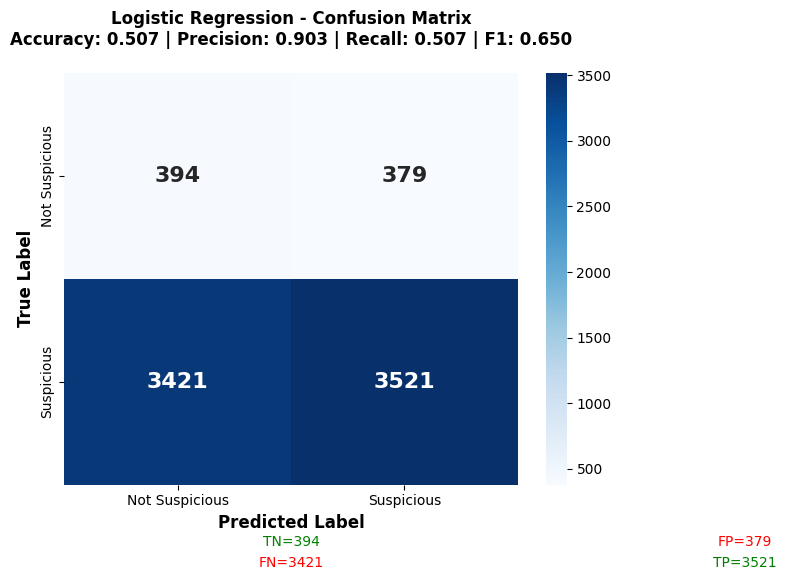


------------------------------------------------------------
Model: Random Forest
------------------------------------------------------------

Confusion Matrix:
[[ 195  578]
 [1767 5175]]

Breakdown:
  True Negatives (TN):    195
  False Positives (FP):   578
  False Negatives (FN):  1767
  True Positives (TP):   5175

Additional Metrics:
  Specificity (TNR):     0.2523
  Sensitivity (Recall):  0.7455
  False Positive Rate:   0.7477
  False Negative Rate:   0.2545


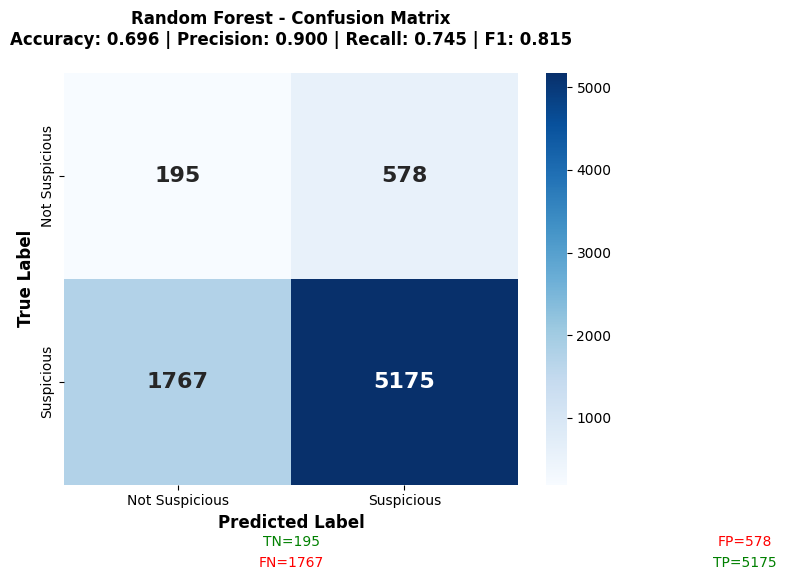


------------------------------------------------------------
Model: Gradient Boosting
------------------------------------------------------------

Confusion Matrix:
[[   3  770]
 [   4 6938]]

Breakdown:
  True Negatives (TN):      3
  False Positives (FP):   770
  False Negatives (FN):     4
  True Positives (TP):   6938

Additional Metrics:
  Specificity (TNR):     0.0039
  Sensitivity (Recall):  0.9994
  False Positive Rate:   0.9961
  False Negative Rate:   0.0006


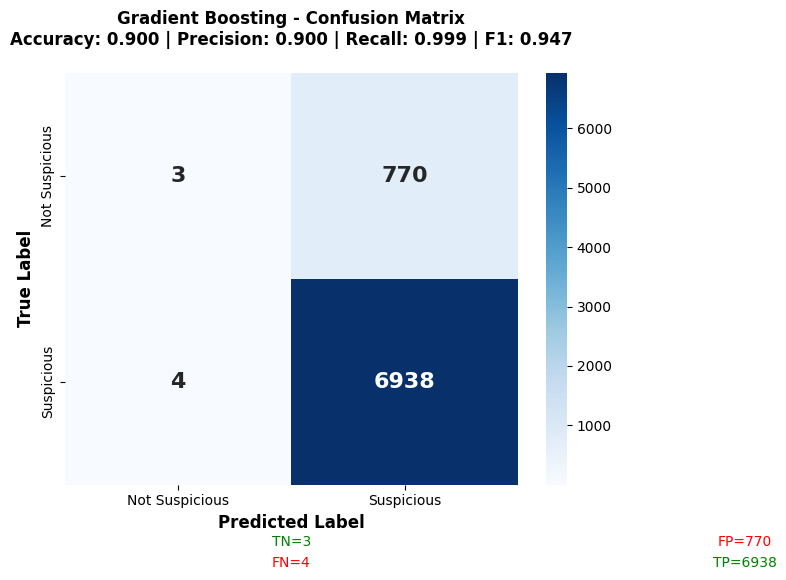

In [42]:
# STEP 11: Individual Confusion Matrices for Each Model
# =====================================================
import matplotlib.pyplot as plt
import seaborn as sns
print("\n" + "="*60)
print("📊 INDIVIDUAL CONFUSION MATRICES FOR EACH MODEL")
print("="*60)

for model_name, predictions in all_predictions.items():
    print(f"\n{'-'*60}")
    print(f"Model: {model_name}")
    print(f"{'-'*60}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predictions['y_pred'])

    # Print numerical confusion matrix
    print(f"\nConfusion Matrix:")
    print(cm)

    # Calculate additional metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    print(f"\nBreakdown:")
    print(f"  True Negatives (TN):  {tn:5d}")
    print(f"  False Positives (FP): {fp:5d}")
    print(f"  False Negatives (FN): {fn:5d}")
    print(f"  True Positives (TP):  {tp:5d}")

    # Calculate rates
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    print(f"\nAdditional Metrics:")
    print(f"  Specificity (TNR):     {specificity:.4f}")
    print(f"  Sensitivity (Recall):  {sensitivity:.4f}")
    print(f"  False Positive Rate:   {fpr:.4f}")
    print(f"  False Negative Rate:   {fnr:.4f}")

    # Create individual confusion matrix visualization
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                ax=ax, cbar=True, annot_kws={"size": 16, "weight": "bold"},
                xticklabels=['Not Suspicious', 'Suspicious'],
                yticklabels=['Not Suspicious', 'Suspicious'])

    # Add title with metrics
    title = f'{model_name} - Confusion Matrix\n'
    title += f'Accuracy: {results[model_name]["accuracy"]:.3f} | '
    title += f'Precision: {results[model_name]["precision"]:.3f} | '
    title += f'Recall: {results[model_name]["recall"]:.3f} | '
    title += f'F1: {results[model_name]["f1"]:.3f}'

    ax.set_title(title, fontsize=12, fontweight='bold', pad=20)
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

    # Add text annotations for better understanding
    ax.text(0.5, -0.15, f'TN={tn}', transform=ax.transAxes,
            ha='center', fontsize=10, color='green')
    ax.text(1.5, -0.15, f'FP={fp}', transform=ax.transAxes,
            ha='center', fontsize=10, color='red')
    ax.text(0.5, -0.2, f'FN={fn}', transform=ax.transAxes,
            ha='center', fontsize=10, color='red')
    ax.text(1.5, -0.2, f'TP={tp}', transform=ax.transAxes,
            ha='center', fontsize=10, color='green')

    plt.tight_layout()
    plt.show()

In [43]:
best_model_name = max(results.items(), key=lambda x: x[1]['f1'])[0]
best_pipeline = results[best_model_name]['pipeline']

print(f"\n{'='*60}")
print(f"🏆 Best Model: {best_model_name}")
print(f"   F1 Score: {results[best_model_name]['f1']:.4f}")
print('='*60)

# Save the best model
joblib.dump(best_pipeline, "fraud_detection_pipeline.pkl")
print("\n✅ Best model saved as 'fraud_detection_pipeline.pkl'")



🏆 Best Model: Gradient Boosting
   F1 Score: 0.9472

✅ Best model saved as 'fraud_detection_pipeline.pkl'


In [44]:
 #STEP 15: Feature Importance (for tree-based models)
# =====================================================
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': best_pipeline.named_steps['classifier'].feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n📊 Top 10 Most Important Features:")
    print(feature_importance.head(10))


📊 Top 10 Most Important Features:
                      feature  importance
0                  amount_usd    0.594237
1           account_txn_count    0.098679
9             aggregate_score    0.081308
10                day_of_week    0.077156
2   beneficiary_country_score    0.037675
12          payment_type_risk    0.034796
3    originator_country_score    0.032562
4             is_cross_border    0.011409
8        rounded_amount_score    0.011145
5    suspicious_keyword_score    0.010539
